
# Trends disaggregated by vegetation group

https://www.dcceew.gov.au/environment/land/native-vegetation/national-vegetation-information-system/data-products#mvg60

In [54]:
%matplotlib inline

import textwrap
import rioxarray as rxr
import numpy as np
import xarray as xr
import pandas as pd
import distinctipy
from odc.geo.xr import assign_crs
import seaborn as sb
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask, round_coords

In [2]:
client = start_local_dask()
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 201939619840 due to system memory limit of 46.00 GiB
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configurati

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40097,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:35861,Total threads: 12
Dashboard: /proxy/38051/status,Memory: 46.00 GiB
Nanny: tcp://127.0.0.1:35619,


In [3]:
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/climate-carbon-interactions/data/aus6_0e_mvg.tif', chunks=(dict(x=250,y=250))).squeeze().drop_vars('band')
ds = ds.where(ds<99).astype('float32')
ds = assign_crs(ds, crs='EPSG:3577')

### Reproject

In [4]:
#reproject
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_gapfilled_1982_2013_0.2.0.nc'
gbox = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326').odc.geobox

ds_coarse = ds.odc.reproject(how=gbox,resampling='mode')
ds_coarse = ds_coarse.rename('NVISv6_5km')
ds_coarse = round_coords(ds_coarse)
ds_coarse = ds_coarse.where(ds_coarse<99)
ds_coarse = ds_coarse.compute()

In [5]:
ds_coarse.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_5km.nc')

### Plot original NVIS

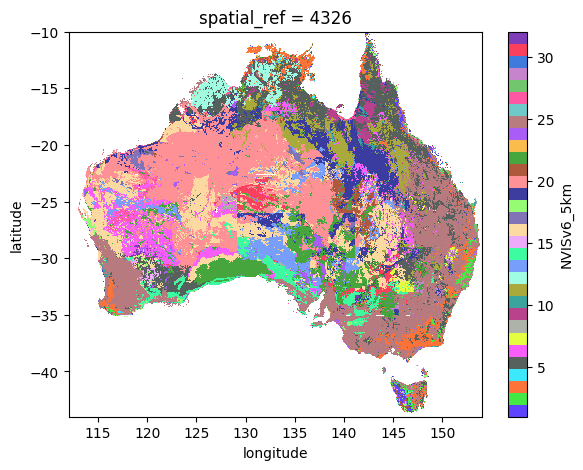

In [52]:
colors = distinctipy.get_colors(32, pastel_factor=0.3)
ds_coarse.plot.imshow(cmap=LinearSegmentedColormap.from_list('d', colors, N=32), size=5);

### Recalssify into simple five categories

* 1=Trees
* 2=shrubs
* 3=grass
* 4=non-native (mask urban and irrigated cropping so ~cropping)
* 5=other

In [7]:
#use this dictionary to create a simpliefied classification
reclassify_dict = {
    1 : [1,2,3,4,5,6,7,8,9,10,11,12,13,30,31], #forest,woodlands
    2 : [14,15,16,17,18,32], #shrublands
    3 : [19,20,21,22], #grasslands  
    4 : [25], #mostly cropping
    5 : [23,24,26,27,28,29] #other
}

#loop through reclassification dictionary and apply simplifed classes.
for k,v in reclassify_dict.items():
    ds = xr.where(ds.isin(v), k, ds)
    
# #remove zeros
ds = ds.where(ds>0)

# add back odc accessor info
ds = assign_crs(ds, crs='EPSG:3577')

In [8]:
ds = ds.odc.reproject(how=gbox,resampling='mode')
ds = round_coords(ds)
# #remove zeros
ds = ds.where(ds>0)
ds = ds.rename('NVISv6_simplified_5km')
ds = ds.compute()

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 20.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [9]:
# #remove zeros
ds = ds.where(ds>0)

In [10]:
ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_simplified_5km.nc')

### Plot simplified NVIS 

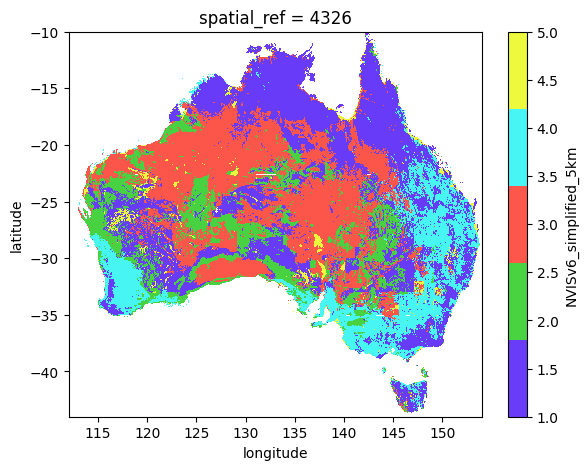

In [53]:
colors = distinctipy.get_colors(5, pastel_factor=0.3)
ds.plot.imshow(cmap=LinearSegmentedColormap.from_list('d', colors, N=5), size=5);

## Map trends across the simple veg groups

In [13]:
nvis_simple = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_simplified_5km.nc')
nvis = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_5km.nc')
p_trends = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/aus_trends_phenology_perpixel.nc'), crs='EPSG:4326')

mask = ~np.isnan(p_trends.vPOS_slope)
nvis_simple = nvis_simple.where(mask)
nvis = nvis.where(mask)
# crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
# crops = xr.where(crops==3, 1, 0) #rainfed crops
# crops = round_coords(crops)

# nvis_simple = xr.where(crops==1,5,nvis_simple) #add rainfed cropping as a class

### Extract pixels over simple veg classes

In [41]:
nvis_simple_names = {
    1:'Forests',
    2:'Shrubs',
    3:'Grasses',
    4:'Non-native\n(rainfed crop)',
    5:'Other'
}

def extract_vars(trends, var, classes_to_extract, nvis, nvis_dict):
    dfs = []
    for c in classes_to_extract: #loop through veg classes
        veg_trends = trends.where(nvis==c)
        df = veg_trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:nvis_dict[c]},axis=1)
        dfs.append(df)

    return pd.concat(dfs).dropna(axis=0, how='all')

simple_classes_to_plot = [1,2,3,4]

NVIS_simple_POS_slopes = extract_vars(p_trends, 'POS_slope', simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_vPOS_slopes = extract_vars(p_trends, 'vPOS_slope',simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_SOS_slopes = extract_vars(p_trends, 'SOS_slope', simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_vSOS_slopes = extract_vars(p_trends, 'vSOS_slope', simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_EOS_slopes = extract_vars(p_trends, 'EOS_slope',simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_vEOS_slopes = extract_vars(p_trends, 'vEOS_slope',simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_LOS_slopes = extract_vars(p_trends, 'LOS_slope',simple_classes_to_plot, nvis_simple, nvis_simple_names)
NVIS_simple_IOS_slopes = extract_vars(p_trends, 'IOS_slope', simple_classes_to_plot, nvis_simple, nvis_simple_names)

### Plot

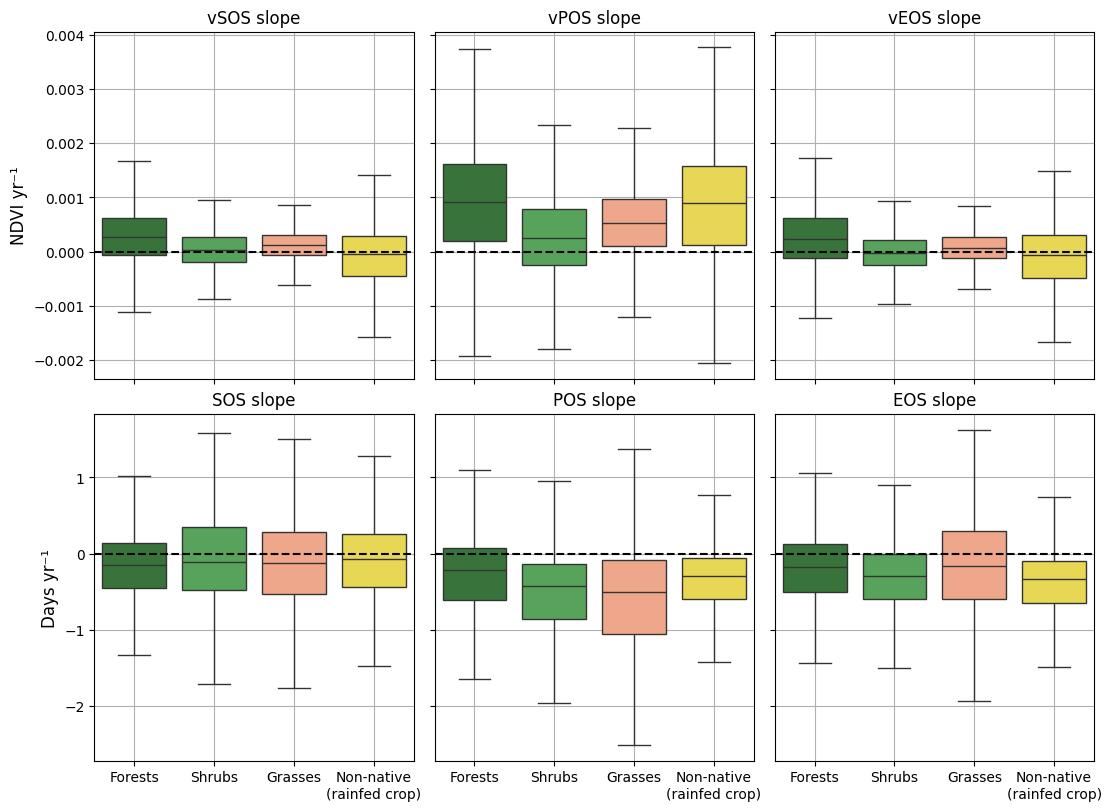

In [42]:
dd = [NVIS_simple_vSOS_slopes, NVIS_simple_vPOS_slopes,NVIS_simple_vEOS_slopes,
      NVIS_simple_SOS_slopes,NVIS_simple_POS_slopes,NVIS_simple_EOS_slopes
]
names=['vSOS slope', 'vPOS slope', 'vEOS slope',
       'SOS slope','POS slope','EOS slope'
]

colors = ['#2E7D32','#4CAF50', 'lightsalmon', '#FFEB3B'] #Forest,Shrub,grass,crop
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colors, N=4)
flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')

fig,axes=plt.subplots(2,3, figsize=(11,8), layout='constrained', sharex=True,sharey='row')

for d,n,ax in zip(dd,names,axes.ravel()):
    sb.boxplot(d, ax=ax, palette=colors,showfliers=False) #
    ax.axhline(0, c='k', linestyle='--')
    ax.set_title(n)
    ax.grid()
    
axes[0,0].set_ylabel('NDVI yr⁻¹', fontsize=12) 
axes[1,0].set_ylabel('Days yr⁻¹', fontsize=12);

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/NVIS_simple_trends_boxplots.png',
            bbox_inches='tight', dpi=300) 

## Map veg trends over all NVIS veg groups

In [43]:
nvis_names = {
    1:'Rainforests and Vine Thickets',
    2:'Eucalypt Tall Open Forests',
    3:'Eucalypt Open Forests',
    4:'Eucalypt Low Open Forests',
    5:'Eucalypt Woodlands',
    6:'Acacia Forests and Woodlands',
    7:'Callitris Forests and Woodlands',
    8:'Casuarina Forests and Woodlands',
    9: 'Melaleuca Forests and Woodlands',
    10:'Other Forests and Woodlands',
    11:'Eucalypt Open Woodlands',
    12:'Tropical Eucalypt Woodlands/Grasslands',
    13:'Acacia Open Woodlands',
    14:'Mallee Woodlands and Shrublands',
    15:'Low Closed Forests and Tall Closed Shrublands',
    16:'Acacia Shrublands',
    17:'Other Shrublands',
    18:'Heathlands',
    19:'Tussock Grasslands',
    20:'Hummock Grasslands',
    21:'Other Grasslands, Herblands, Sedgelands and Rushlands',
    22:'Chenopod Shrublands, Samphire Shrublands and Forblands',
    23:'Mangroves',
    24:'Inland Aquatic - freshwater, salt lakes, lagoons',
    25:'Cleared, non-native vegetation, buildings',
    26:'Unclassified native vegetation',
    27:'Naturally bare - sand, rock, claypan, mudflat',
    28:'Sea and estuaries',
    29:'Regrowth, modified native vegetation',
    30:'Unclassified forest',
    31:'Other Open Woodlands',
    32:'Mallee Open Woodlands and Sparse Mallee Shrublands'
}

#list of classes we will analyse
classes_to_plot = [i for i in range(1,23)]+[32]

# nvis but with only classes we'll plot
nvis_plot = nvis.where(nvis.isin(classes_to_plot))

### Extract pixels over veg groups

In [44]:
NVIS_POS_slopes = extract_vars(p_trends, 'POS_slope', classes_to_plot, nvis, nvis_names)
NVIS_vPOS_slopes = extract_vars(p_trends, 'vPOS_slope', classes_to_plot, nvis, nvis_names)
NVIS_SOS_slopes = extract_vars(p_trends, 'SOS_slope', classes_to_plot, nvis, nvis_names)
NVIS_vSOS_slopes = extract_vars(p_trends, 'vSOS_slope', classes_to_plot, nvis, nvis_names)
NVIS_EOS_slopes = extract_vars(p_trends, 'EOS_slope', classes_to_plot, nvis, nvis_names)
NVIS_vEOS_slopes = extract_vars(p_trends, 'vEOS_slope', classes_to_plot, nvis, nvis_names)
NVIS_LOS_slopes = extract_vars(p_trends, 'LOS_slope', classes_to_plot, nvis, nvis_names)
NVIS_IOS_slopes = extract_vars(p_trends, 'IOS_slope', classes_to_plot, nvis, nvis_names)

### Plot POS

In [ ]:
dd = [NVIS_vSOS_slopes, NVIS_vPOS_slopes,NVIS_vEOS_slopes,
      NVIS_SOS_slopes,NVIS_POS_slopes,NVIS_EOS_slopes
]
names=['vSOS slope', 'vPOS slope', 'vEOS slope',
       'SOS slope','POS slope','EOS slope'
]

colors = ['#2E7D32','#4CAF50', 'lightsalmon', '#FFEB3B'] #Forest,Shrub,grass,crop
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colors, N=4)
flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')

fig,axes=plt.subplots(2,3, figsize=(11,8), layout='constrained', sharex=True,sharey='row')

for d,n,ax in zip(dd,names,axes.ravel()):
    sb.boxplot(d, ax=ax, palette=colors,showfliers=False) #
    ax.axhline(0, c='k', linestyle='--')
    ax.set_title(n)
    ax.grid()
    
axes[0,0].set_ylabel('NDVI yr⁻¹', fontsize=12) 
axes[1,0].set_ylabel('Days yr⁻¹', fontsize=12);

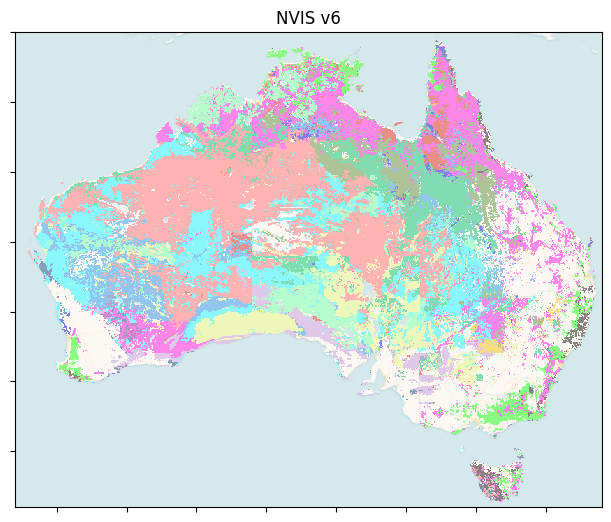

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), layout='constrained')

colors = distinctipy.get_colors(idxes, pastel_factor=1, rng=1)
cmap=LinearSegmentedColormap.from_list('d', colors, N=idxes)
im=nvis_plot.plot(cmap=cmap,ax=ax, add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels,
                crs='EPSG:4326', attribution='', attribution_size=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('NVIS v6');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/NVIS_plot.png',
            bbox_inches='tight', dpi=300) 

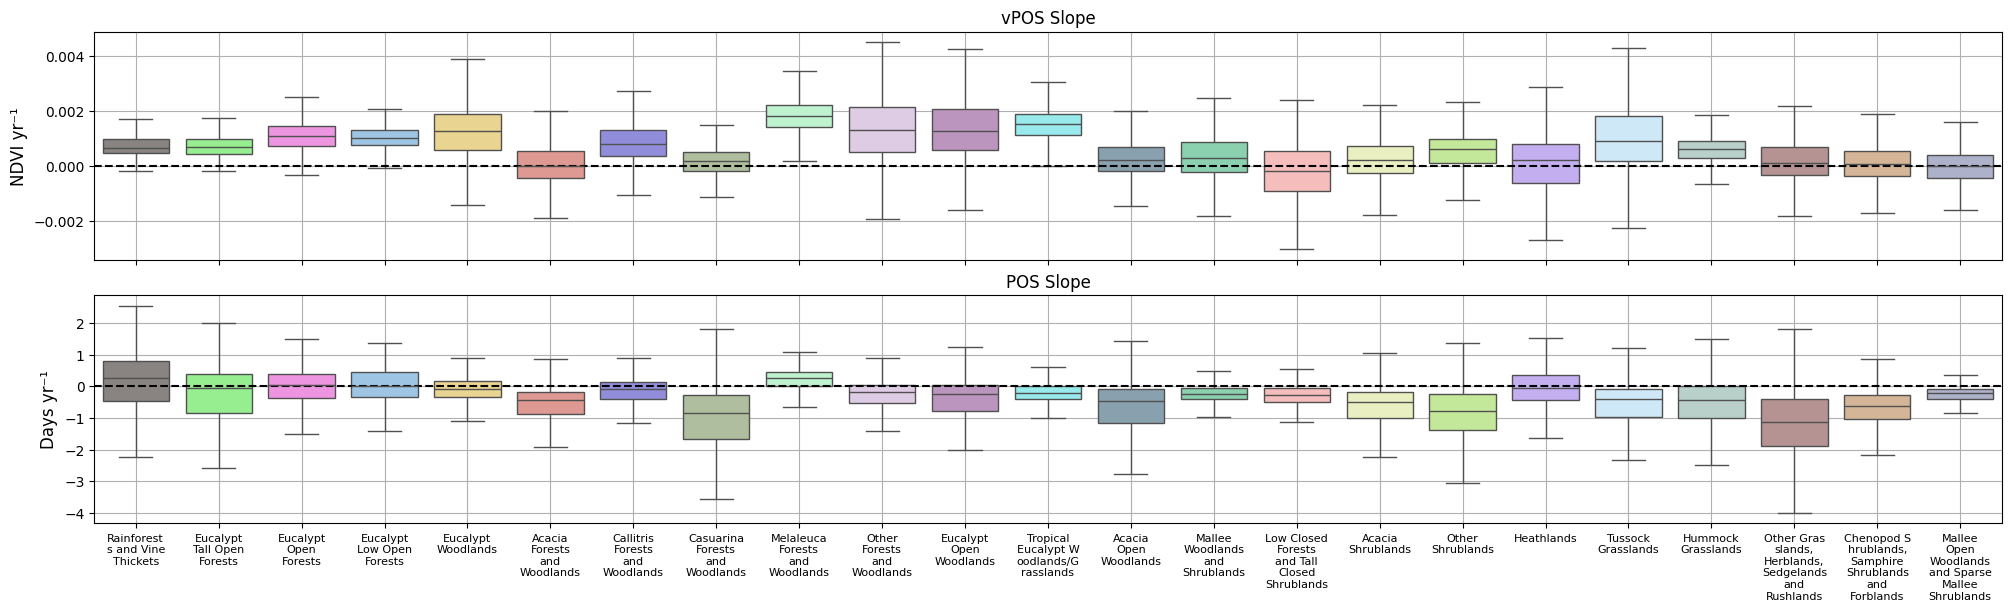

In [49]:
layout = [
    ['B','B', 'B', 'B', 'B', 'B'],
    ['C', 'C', 'C', 'C', 'C', 'C']
]
idxes = len(classes_to_plot)
# Create the mosaic plot
fig, ax = plt.subplot_mosaic(layout, figsize=(20, 6), layout='constrained')

sb.boxplot(NVIS_vPOS_slopes, ax=ax['B'], palette=colors, showfliers=False)
ax['B'].set_ylabel('NDVI yr⁻¹', fontsize=12)
# ax['B'].set_ylim(-0.004, 0.006)
ax['B'].axhline(0, c='k', linestyle='--')
ax['B'].set_title('vPOS Slope')
ax['B'].tick_params(labelbottom=False)
ax['B'].grid()

sb.boxplot(NVIS_POS_slopes, ax=ax['C'], palette=colors, showfliers=False)
ax['C'].set_ylabel('Days yr⁻¹', fontsize=12)
ax['C'].grid()
ax['C'].axhline(0, c='k', linestyle='--')
ax['C'].set_title('POS Slope')
ax['C'].set_xticks(range(0,idxes), [textwrap.fill(label, 10) for label in {k: nvis_names[k] for k in classes_to_plot}.values()], 
                        fontsize=8, horizontalalignment="center")

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/NVIS_trends_POS.png',
            bbox_inches='tight', dpi=300) 

### Plot SOS

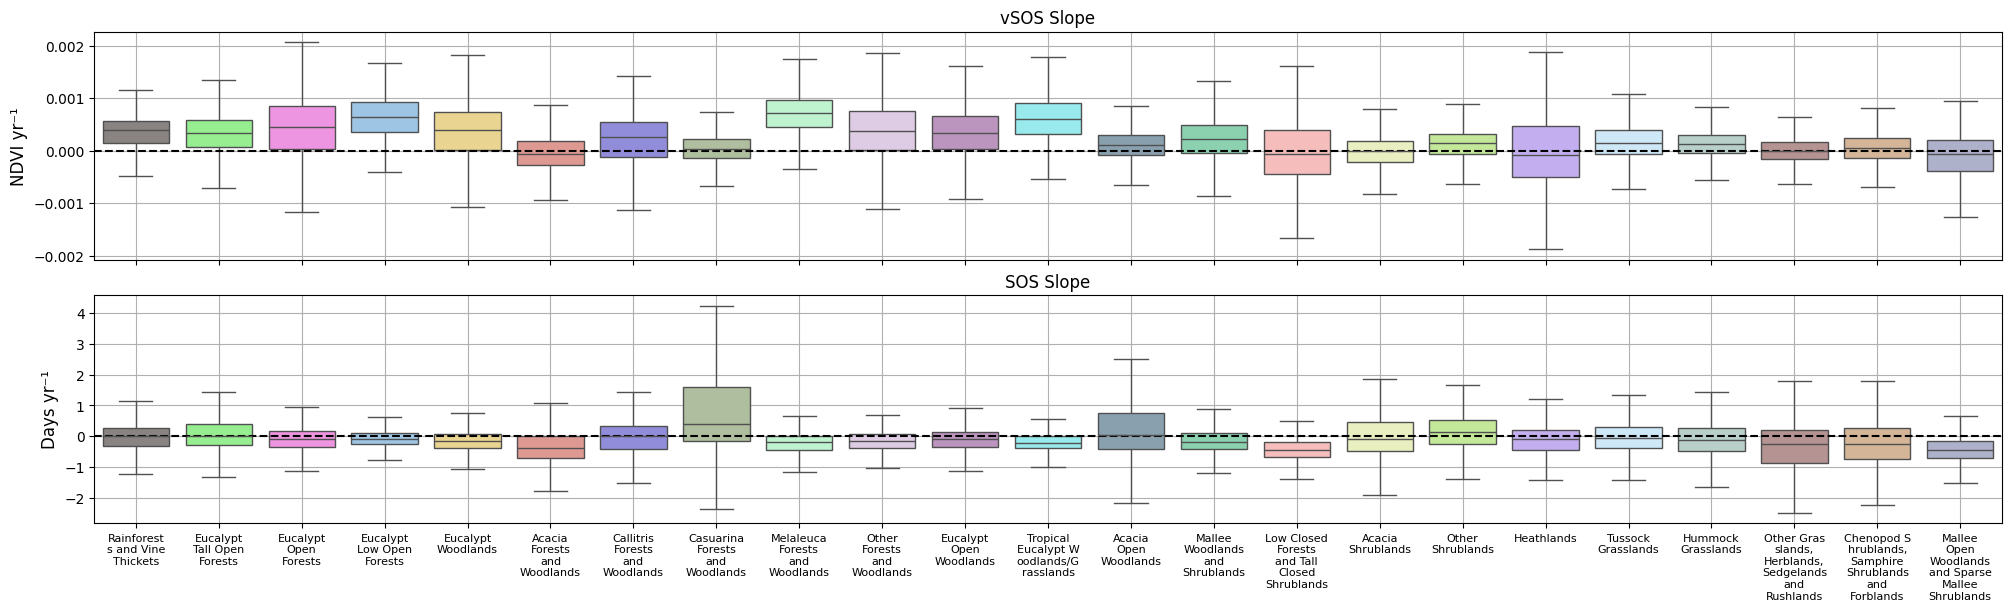

In [50]:
layout = [
    ['B','B', 'B', 'B', 'B', 'B'],
    ['C', 'C', 'C', 'C', 'C', 'C']
]
idxes = len(classes_to_plot)
# Create the mosaic plot
fig, ax = plt.subplot_mosaic(layout, figsize=(20, 6), layout='constrained')

sb.boxplot(NVIS_vSOS_slopes, ax=ax['B'], palette=colors, showfliers=False)
ax['B'].set_ylabel('NDVI yr⁻¹', fontsize=12)
# ax['B'].set_ylim(-0.004, 0.006)
ax['B'].axhline(0, c='k', linestyle='--')
ax['B'].set_title('vSOS Slope')
ax['B'].tick_params(labelbottom=False)
ax['B'].grid()

sb.boxplot(NVIS_SOS_slopes, ax=ax['C'], palette=colors, showfliers=False)
ax['C'].set_ylabel('Days yr⁻¹', fontsize=12)
ax['C'].grid()
ax['C'].axhline(0, c='k', linestyle='--')
ax['C'].set_title('SOS Slope')
ax['C'].set_xticks(range(0,idxes), [textwrap.fill(label, 10) for label in {k: nvis_names[k] for k in classes_to_plot}.values()], 
                        fontsize=8, horizontalalignment="center")

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/NVIS_trends_SOS.png',
            bbox_inches='tight', dpi=300)  

### Plot EOS

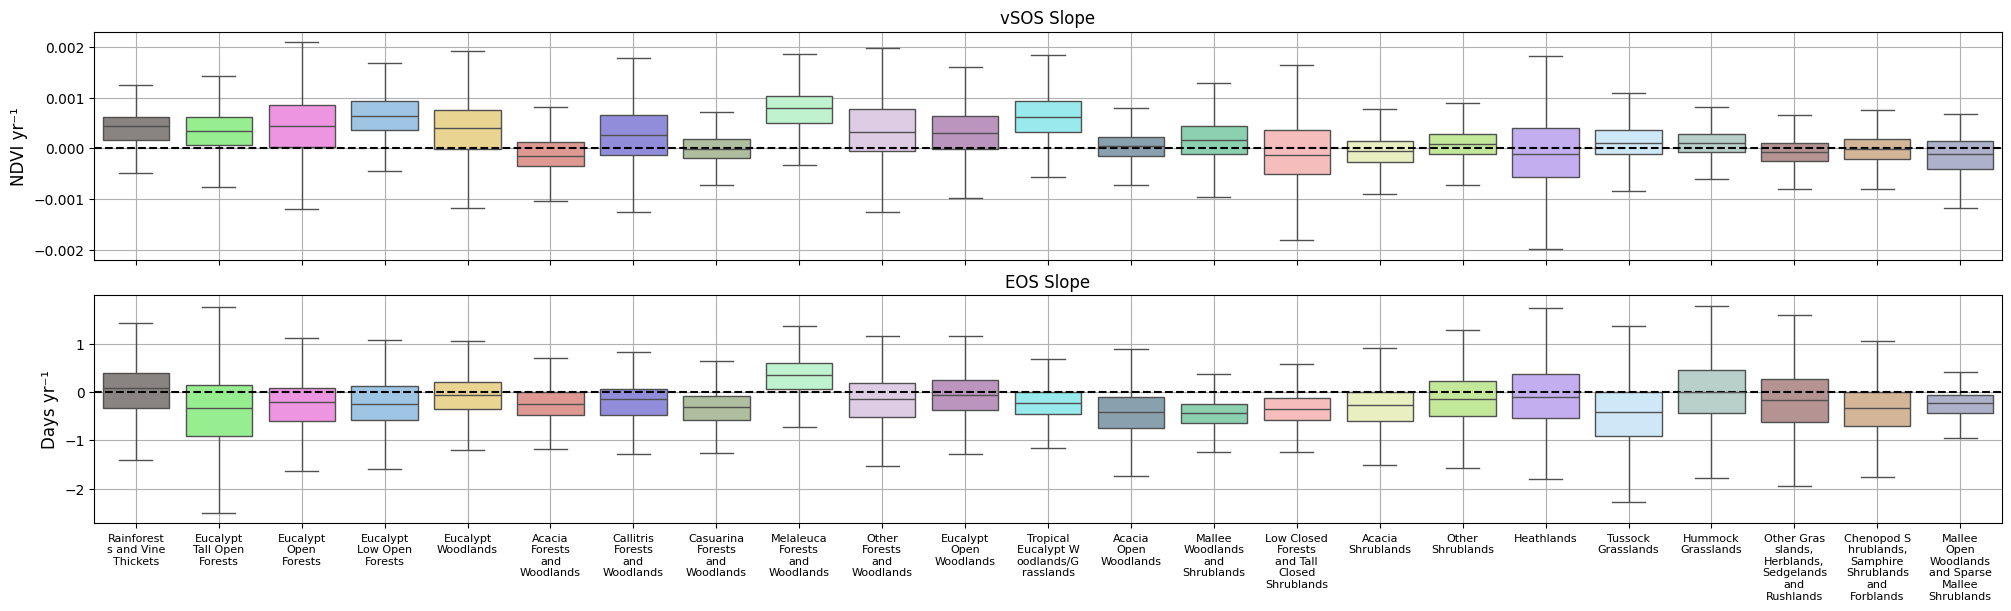

In [51]:
layout = [
    ['B','B', 'B', 'B', 'B', 'B'],
    ['C', 'C', 'C', 'C', 'C', 'C']
]
idxes = len(classes_to_plot)
# Create the mosaic plot
fig, ax = plt.subplot_mosaic(layout, figsize=(20, 6), layout='constrained')

sb.boxplot(NVIS_vEOS_slopes, ax=ax['B'], palette=colors, showfliers=False)
ax['B'].set_ylabel('NDVI yr⁻¹', fontsize=12)
# ax['B'].set_ylim(-0.004, 0.006)
ax['B'].axhline(0, c='k', linestyle='--')
ax['B'].set_title('vSOS Slope')
ax['B'].tick_params(labelbottom=False)
ax['B'].grid()

sb.boxplot(NVIS_EOS_slopes, ax=ax['C'], palette=colors, showfliers=False)
ax['C'].set_ylabel('Days yr⁻¹', fontsize=12)
ax['C'].grid()
ax['C'].axhline(0, c='k', linestyle='--')
ax['C'].set_title('EOS Slope')
ax['C'].set_xticks(range(0,idxes), [textwrap.fill(label, 10) for label in {k: nvis_names[k] for k in classes_to_plot}.values()], 
                        fontsize=8, horizontalalignment="center")

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/NVIS_trends_EOS.png',
            bbox_inches='tight', dpi=300)  

### Plot LOS/IOS


In [ ]:
# layout = [
#     ['A','A', 'B','B', 'B', 'B', 'B', 'B'],
#     ['A','A','C', 'C', 'C', 'C', 'C', 'C']
# ]
# idxes = len(classes_to_plot)
# # Create the mosaic plot
# with plt.style.context('ggplot'):
#     fig, ax = plt.subplot_mosaic(layout, figsize=(20, 6), layout='constrained')

#     colors = distinctipy.get_colors(idxes, pastel_factor=1, rng=1)
#     cmap=LinearSegmentedColormap.from_list('d', colors, N=idxes)
#     im=nvis_plot.plot(cmap=cmap,ax=ax['A'], add_labels=False, add_colorbar=False)
#     ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.VoyagerNoLabels,
#                     crs='EPSG:4326', attribution='', attribution_size=1)
#     ax['A'].set_yticklabels([])
#     ax['A'].set_xticklabels([])
#     ax['A'].set_title('NVIS v6')
    
#     sb.violinplot(NVIS_LOS_slopes, ax=ax['B'], palette=colors)
#     ax['B'].set_ylabel('Days yr⁻¹', fontsize=12)
#     ax['B'].set_ylim(-3, 4)
#     ax['B'].axhline(0, c='k', linestyle='--')
#     ax['B'].set_title('LOS Slope')
#     ax['B'].tick_params(labelbottom=False)   

#     sb.violinplot(NVIS_IOS_slopes, ax=ax['C'], palette=colors)
#     ax['C'].set_ylabel('NDVI yr⁻¹', fontsize=12)
#     ax['C'].set_ylim(-2, 2)
#     ax['C'].axhline(0, c='k', linestyle='--')
#     ax['C'].set_title('IOS Slope')
#     ax['C'].set_xticks(range(0,idxes), [textwrap.fill(label, 9) for label in {k: nvis_names[k] for k in classes_to_plot}.values()], 
#                             fontsize=8, horizontalalignment="center")

# # plt.tight_layout()
# fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/NVIS_trends_LOS.png',
#             bbox_inches='tight', dpi=300) 